In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv(r'C:\Users\Qianyu\Downloads\competitive-data-science-predict-future-sales/sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                           'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})
test = pd.read_csv(r'C:\Users\Qianyu\Downloads\competitive-data-science-predict-future-sales/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})
submission = pd.read_csv(r'C:\Users\Qianyu\Downloads\competitive-data-science-predict-future-sales/sample_submission.csv')
items = pd.read_csv(r'C:\Users\Qianyu\Downloads\competitive-data-science-predict-future-sales/items.csv')
item_cats = pd.read_csv(r'C:\Users\Qianyu\Downloads\competitive-data-science-predict-future-sales/item_categories.csv')
shops = pd.read_csv(r'C:\Users\Qianyu\Downloads\competitive-data-science-predict-future-sales/shops.csv')

In [3]:
train = train.merge(items, how = 'left',on='item_id').merge(shops, how = 'left',on='shop_id').merge(item_cats, how = 'left',on='item_category_id')
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-02-01,0,59,22154,999.000000,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,2013-03-01,0,25,2552,899.000000,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,2013-05-01,0,25,2552,899.000000,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,2013-06-01,0,25,2554,1709.050049,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,2013-01-15,0,25,2555,1099.000000,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства
...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.000000,1,V/A Nu Jazz Selection (digipack),55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935845,2015-09-10,33,25,7460,299.000000,1,V/A The Golden Jazz Collection 1 2CD,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935846,2015-10-14,33,25,7459,349.000000,1,V/A The Best Of The 3 Tenors,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935847,2015-10-22,33,25,7440,299.000000,1,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,"Москва ТРК ""Атриум""",Музыка - MP3


In [4]:
test_items = test.item_id.unique()
test_shops = test.shop_id.unique()
train_f = train[train['item_id'].isin(test_items)]
train_f = train_f[train_f['shop_id'].isin(test_shops)]
train_f = train_f[train_f['item_price']>0]

In [5]:
train_monthly = train_f[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly.head()

,date,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_day
57119,2013-01-01,0,14,30,2808,999.00,2
16686,2013-01-01,0,28,55,10928,199.00,1
16290,2013-01-01,0,28,19,13511,1598.75,2
15689,2013-01-01,0,28,5,5583,699.00,1
15680,2013-01-01,0,28,2,5572,1590.00,1
...,...,...,...,...,...,...,...
2893291,2015-12-10,33,38,40,17775,399.00,1
2893289,2015-12-10,33,38,37,17774,749.00,1
2893275,2015-12-10,33,38,55,18511,229.00,1
2893265,2015-12-10,33,38,55,18439,229.00,1


In [6]:
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})

In [7]:
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [8]:
#fill all the prob

shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)

In [9]:
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: (x//12)+2013)
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: x%12)

In [10]:
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

Text(0.5, 1.0, 'Monthly sum')

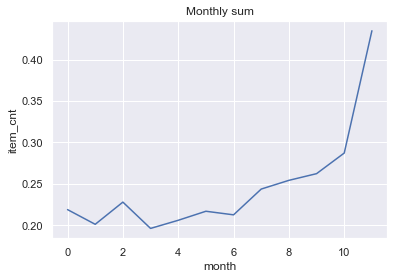

In [11]:
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()
fig= plt.plot(figure_size=(20,10))
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean).set_title("Monthly sum")

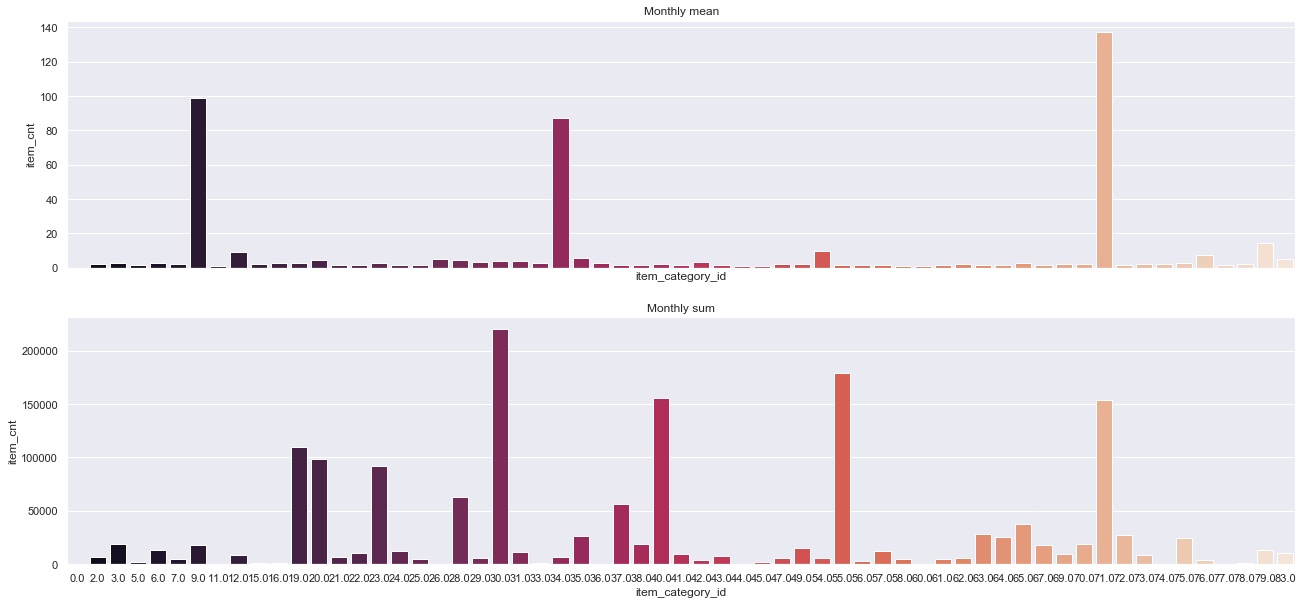

In [12]:
gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

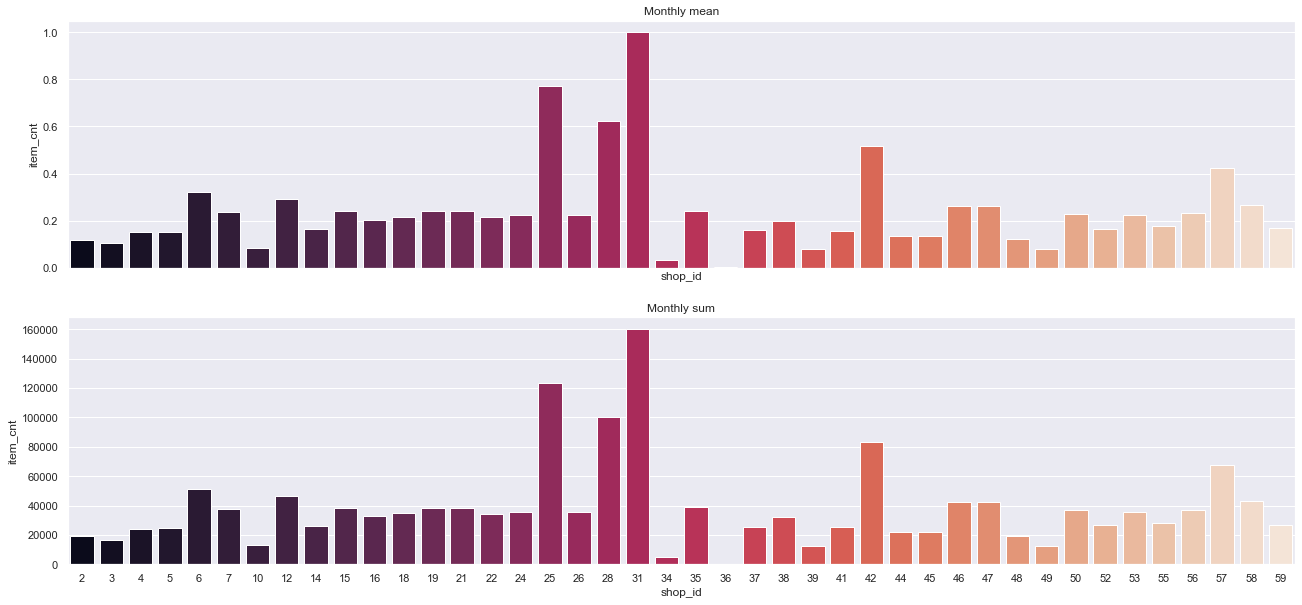

In [13]:
gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

<h6>outliners<h6>

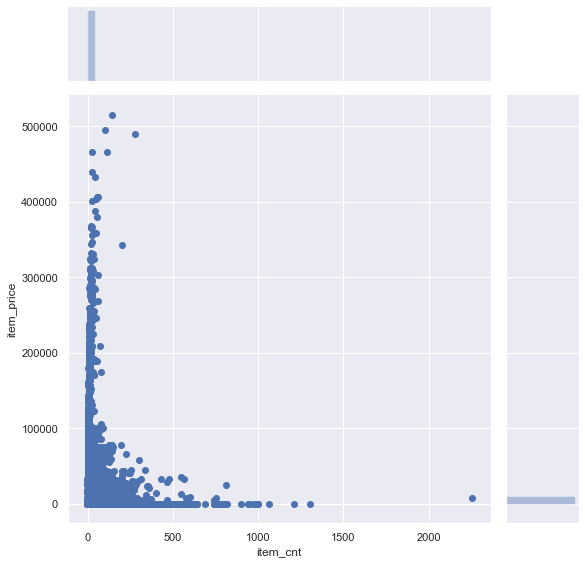

In [14]:
sns.jointplot(x="item_cnt", y="item_price", data=train_monthly, height=8)
plt.show()

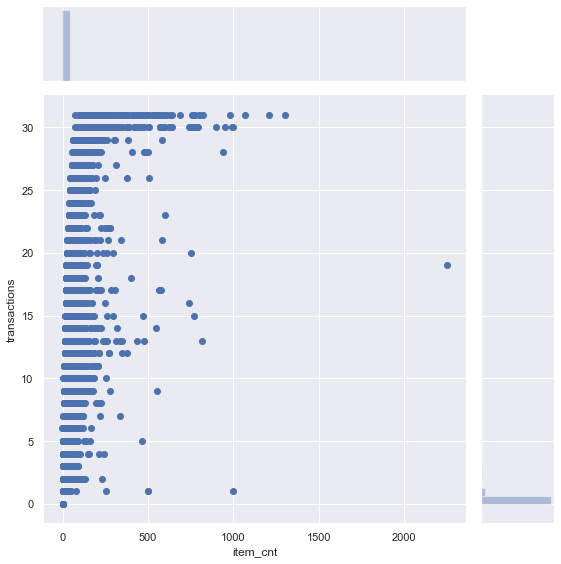

In [15]:
sns.jointplot(x="item_cnt", y="transactions", data=train_monthly, height=8)
plt.show()

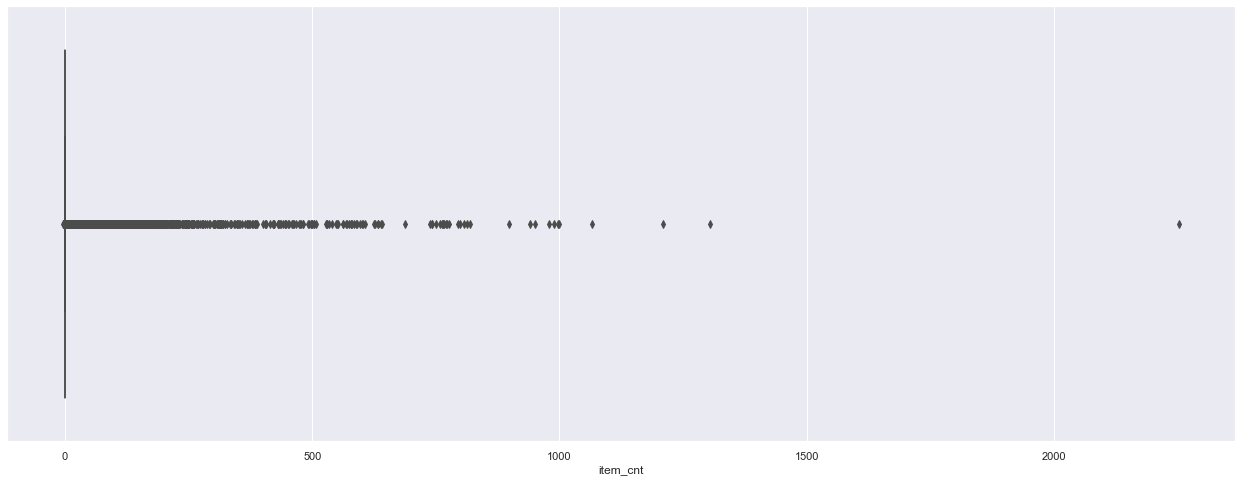

In [16]:
plt.subplots(figsize=(22, 8))
sns.boxplot(train_monthly['item_cnt'])
plt.show()

In [17]:
#remove outliners

train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20 and item_price < 400000')


In [18]:
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

In [19]:
train_monthly['item_price_unit'] = train_monthly['item_price']//train_monthly['item_cnt']
train_monthly['item_price_unit'].fillna(0,inplace=True)

In [20]:
gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

In [22]:
train_monthly = pd.merge(train_monthly, gp_item_price, on='item_id', how='left')

In [23]:
train_monthly['price_increase'] = train_monthly['item_price'] - train_monthly['hist_min_item_price']
train_monthly['price_decrease'] = train_monthly['hist_max_item_price'] - train_monthly['item_price']

In [24]:
train_monthly

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,0,1.00,1192.00,0.00,18979.50,10730.00,8249.50
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00,2013,0,0.00,inf,0.00,35260.00,4775.21,30484.79
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,0,1.00,594.00,0.00,5592.00,1188.30,4403.70
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,0,2.00,1990.00,0.00,27950.00,5970.00,21980.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,0,2.00,1490.00,0.00,25880.00,1490.00,24390.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6728113,33,36,9103,0.00,0.00,0.00,0.00,0.00,0.00,2015,9,nan,0.00,0.00,500.00,0.00,500.00
6728114,33,36,9107,0.00,0.00,0.00,0.00,0.00,0.00,2015,9,nan,0.00,0.00,300.00,0.00,300.00
6728115,33,36,5704,0.00,0.00,0.00,0.00,0.00,0.00,2015,9,nan,0.00,0.00,1750.00,0.00,1750.00
6728116,33,36,12733,0.00,0.00,0.00,0.00,0.00,0.00,2015,9,nan,0.00,0.00,2980.00,0.00,2980.00


In [25]:
#the rolling window to get the information of previous month
# windows above
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    train_monthly[('item_cnt_%s' % function_name[i])] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

# Fill the empty std features with 0
train_monthly['item_cnt_std'].fillna(0, inplace=True)

In [26]:
lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)

In [27]:
train_monthly['item_trend'] = train_monthly['item_cnt']

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly['item_trend'] -= train_monthly[ft_name]

train_monthly['item_trend'] /= len(lag_list) + 1

In [33]:
train_set = train_monthly.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = train_monthly.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = train_monthly.query('date_block_num == 33').copy()

train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

In [34]:
validation_set

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
5540664,28,2,5572,2.00,1590.00,1590.00,1.00,1.00,1.00,2015,...,1590.00,17389.50,1.00,1.00,1.00,0.00,1.00,1.00,1.00,-0.50
5540665,28,2,5643,0.00,0.00,0.00,0.00,0.00,0.00,2015,...,0.00,35260.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5540666,28,2,5583,0.00,0.00,0.00,0.00,0.00,0.00,2015,...,0.00,5592.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5540667,28,2,7893,0.00,0.00,0.00,0.00,0.00,0.00,2015,...,0.00,27950.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5540668,28,2,7894,6.00,4579.50,2289.75,2.00,1.00,2.00,2015,...,4579.50,21300.50,1.00,5.00,2.67,2.08,1.00,5.00,2.00,-1.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6530234,32,36,9103,0.00,0.00,0.00,0.00,0.00,0.00,2015,...,0.00,500.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6530235,32,36,9107,0.00,0.00,0.00,0.00,0.00,0.00,2015,...,0.00,300.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6530236,32,36,5704,0.00,0.00,0.00,0.00,0.00,0.00,2015,...,0.00,1750.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6530237,32,36,12733,0.00,0.00,0.00,0.00,0.00,0.00,2015,...,0.00,2980.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [35]:
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)
gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)
# Shop with item mean encoding.
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)
# Year mean encoding.
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# Month mean encoding.
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

# Add meand encoding features to train set.
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')
# Add meand encoding features to validation set.
validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')

In [36]:
validation_set

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,...,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
0,28,2,5572,2.00,1590.00,1590.00,1.00,1.00,1.00,2015,...,0.00,1.00,1.00,1.00,-0.50,0.10,1.00,0.84,0.22,0.14
1,28,2,5643,0.00,0.00,0.00,0.00,0.00,0.00,2015,...,0.00,0.00,0.00,0.00,0.00,0.10,1.82,1.84,0.22,0.14
2,28,2,5583,0.00,0.00,0.00,0.00,0.00,0.00,2015,...,0.00,0.00,0.00,0.00,0.00,0.10,0.59,0.04,0.22,0.14
3,28,2,7893,0.00,0.00,0.00,0.00,0.00,0.00,2015,...,0.00,0.00,0.00,0.00,0.00,0.10,3.04,3.12,0.22,0.14
4,28,2,7894,6.00,4579.50,2289.75,2.00,1.00,2.00,2015,...,2.08,1.00,5.00,2.00,-1.50,0.10,3.67,1.68,0.22,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989407,32,36,9103,0.00,0.00,0.00,0.00,0.00,0.00,2015,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,0.17
989408,32,36,9107,0.00,0.00,0.00,0.00,0.00,0.00,2015,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,0.17
989409,32,36,5704,0.00,0.00,0.00,0.00,0.00,0.00,2015,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,0.17
989410,32,36,12733,0.00,0.00,0.00,0.00,0.00,0.00,2015,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,0.17


In [37]:
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

In [38]:
Y_validation = Y_validation.reset_index().drop(['index'], axis = 1)
Y_train = Y_train.reset_index().drop(['index'], axis = 1)

In [40]:
# Integer features (used by catboost model).
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

In [41]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

In [42]:
sets = [X_train, X_validation, X_test]

# Replace missing values with the median of each shop.            
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
# Fill remaining missing values on test set with mean.
X_test.fillna(X_test.mean(), inplace=True)

In [43]:
# Integer features (used by catboost model).
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')
X_test[int_features] = X_test[int_features].astype('int32')

In [44]:
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

In [45]:
X_validation

,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_price_unit,...,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
0,2,5572,1590.00,1590.00,1.00,1.00,1.00,2015,4,1590.00,...,0.00,1.00,1.00,1.00,-0.50,0.10,1.00,0.84,0.22,0.14
1,2,5643,0.00,0.00,0.00,0.00,0.00,2015,4,0.00,...,0.00,0.00,0.00,0.00,0.00,0.10,1.82,1.84,0.22,0.14
2,2,5583,0.00,0.00,0.00,0.00,0.00,2015,4,0.00,...,0.00,0.00,0.00,0.00,0.00,0.10,0.59,0.04,0.22,0.14
3,2,7893,0.00,0.00,0.00,0.00,0.00,2015,4,0.00,...,0.00,0.00,0.00,0.00,0.00,0.10,3.04,3.12,0.22,0.14
4,2,7894,4579.50,2289.75,2.00,1.00,2.00,2015,4,2289.00,...,2.08,1.00,5.00,2.00,-1.50,0.10,3.67,1.68,0.22,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989407,36,9103,0.00,0.00,0.00,0.00,0.00,2015,8,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,0.17
989408,36,9107,0.00,0.00,0.00,0.00,0.00,2015,8,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,0.17
989409,36,5704,0.00,0.00,0.00,0.00,0.00,2015,8,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,0.17
989410,36,12733,0.00,0.00,0.00,0.00,0.00,2015,8,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,0.17


item_cnt_shifted1,2,3  sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt']. last month's vlaue
item_trend         item_cnt-item_cnz_shifted1,2,3
shop_mean          groupby(['shop_id']).agg({'item_cnt_month': ['mean']}
mean_item_price,item_cnt,mean_item_cnt,transactions
                sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
                agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
item_cnt_month      sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)   #next month cnt
item_mean          groupby(['item_id']).agg({'item_cnt_month': ['mean']})
shop_item_mean      groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
year_mean         groupby(['year']).agg({'item_cnt_month': ['mean']})
month_mean         groupby(['month']).agg({'item_cnt_month': ['mean']})

In [46]:
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [47]:
cat_features = [0, 1, 7, 8]

catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_validation, Y_validation)
)

Learning rate set to 0.354206
0:	learn: 0.8169921	test: 0.8679482	best: 0.8679482 (0)	total: 2.54s	remaining: 21m 7s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.8122146
bestIteration = 4

Shrink model to first 5 iterations.


In [48]:
print('Model params:', catboost_model.get_params())

Model params: {'iterations': 500, 'depth': 4, 'loss_function': 'RMSE', 'od_wait': 25, 'od_type': 'Iter', 'random_seed': 0, 'verbose': 50, 'max_ctr_complexity': 4}


In [50]:
catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_validation)
catboost_test_pred = catboost_model.predict(X_test)

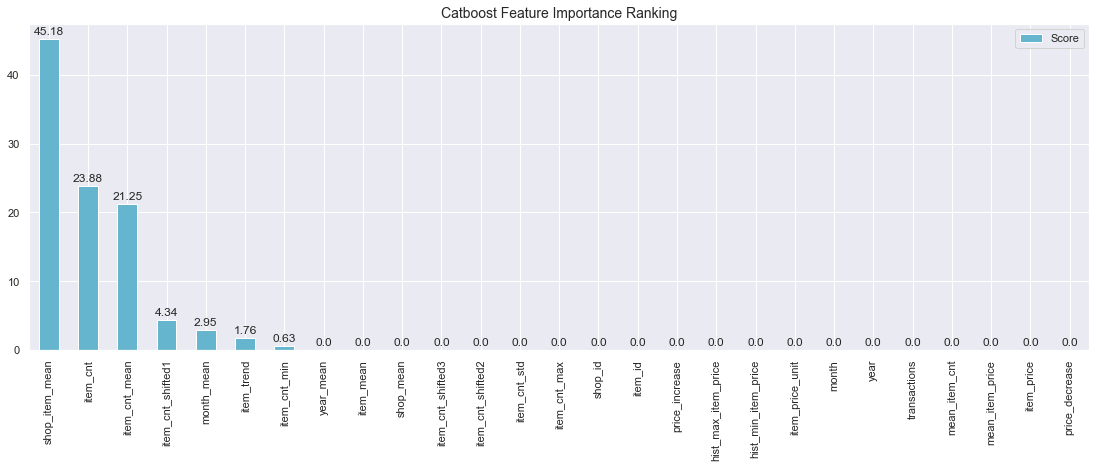

In [52]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, catboost_model.get_feature_importance(Pool(X_train, label=Y_train, cat_features=cat_features)))), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (19, 6)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

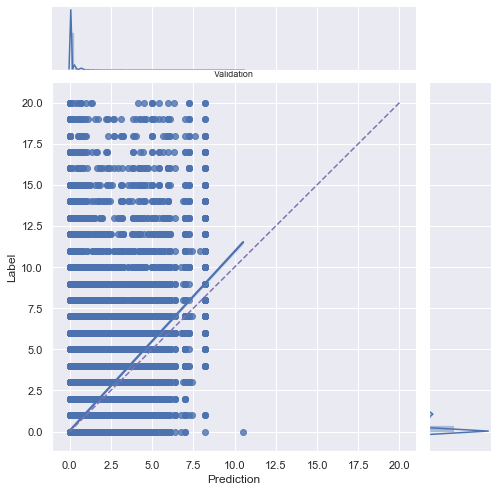

In [53]:
def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg", height=7)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()
    
# model_performance_sc_plot(catboost_train_pred, Y_train, 'Train')
model_performance_sc_plot(catboost_val_pred, Y_validation.item_cnt_month, 'Validation')

<h4>XGBboost<h4>

In [54]:
xgb_features = ['item_cnt','item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'shop_mean', 
                'shop_item_mean', 'item_trend', 'mean_item_cnt']
xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_test = X_test[xgb_features]

In [55]:
xgb_model = XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)], 
              verbose=20, 
              early_stopping_rounds=20)

[12:14:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:38] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:0.942842	validation_1-rmse:0.92285
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:0.684505	validation_1-rmse:0.790798
Stopping. Best iteration:
[18]	validation_0-rmse:0.687606	validation_1-rmse:0.788279



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1000, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=None,
             subsample=0.7, verbosity=1)

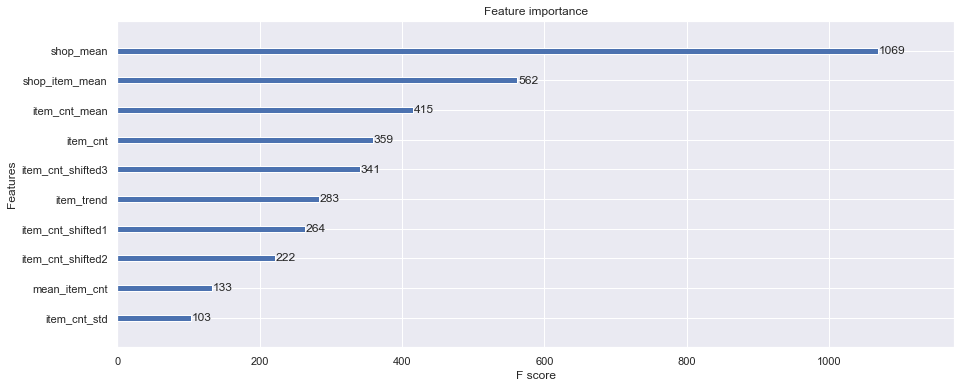

In [56]:
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgb_model)
plt.show()

In [57]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

In [58]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, xgb_val_pred)))

Train rmse: 0.6921620336737511
Validation rmse: 0.7898067075909768


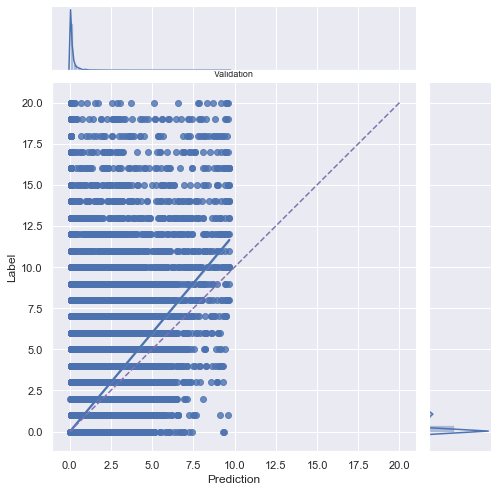

In [59]:
model_performance_sc_plot(xgb_val_pred, Y_validation.item_cnt_month, 'Validation')

<h4>Random Forest

In [60]:
rf_features = ['shop_id', 'item_id', 'item_cnt', 'transactions', 'year',
               'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
               'shop_mean', 'item_mean', 'item_trend', 'mean_item_cnt']
rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]

In [61]:
rf_test.isna().sum()

shop_id              0
item_id              0
item_cnt             0
transactions         0
year                 0
item_cnt_mean        0
item_cnt_std         0
item_cnt_shifted1    0
shop_mean            0
item_mean            0
item_trend           0
mean_item_cnt        0
dtype: int64

In [62]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [63]:
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

In [64]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, rf_val_pred)))

Train rmse: 0.6985868322226099
Validation rmse: 0.776123635046122


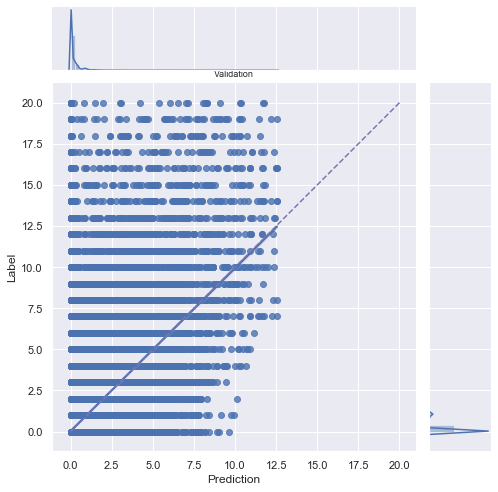

In [65]:
model_performance_sc_plot(rf_val_pred, Y_validation.item_cnt_month, 'Validation')

<h4>Linear model

In [66]:
lr_features = ['item_cnt', 'item_cnt_shifted1', 'item_trend', 'mean_item_cnt', 'shop_mean']
lr_train = X_train[lr_features]
lr_val = X_validation[lr_features]
lr_test = X_test[lr_features]

In [67]:
lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)
lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)

In [68]:
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [69]:
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)

In [70]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, lr_val_pred)))

Train rmse: 0.7347132326333321
Validation rmse: 0.775531109353132


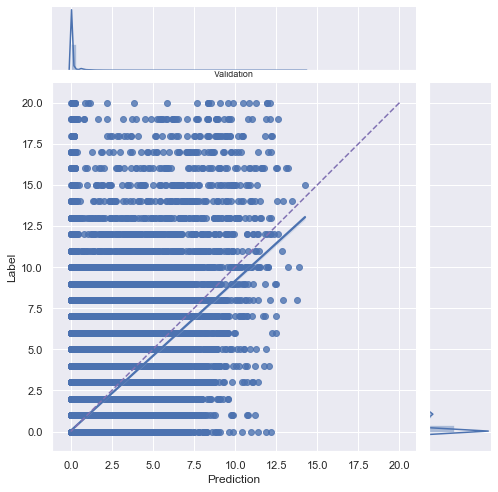

In [71]:
model_performance_sc_plot(lr_val_pred, Y_validation.item_cnt_month, 'Validation')

<h4>Clustering

In [72]:
knn_features = ['item_cnt', 'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1',
                'item_cnt_shifted2', 'shop_mean', 'shop_item_mean', 
                'item_trend', 'mean_item_cnt']

# Subsample train set (using the whole data was taking too long).
X_train_sampled = X_train[:100000]
Y_train_sampled = Y_train[:100000]

knn_train = X_train_sampled[knn_features]
knn_val = X_validation[knn_features]
knn_test = X_test[knn_features]

In [73]:
knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
knn_val = knn_scaler.transform(knn_val)
knn_test = knn_scaler.transform(knn_test)

In [74]:
knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(knn_train, Y_train_sampled)

KNeighborsRegressor(algorithm='auto', leaf_size=13, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                    weights='uniform')

In [75]:
knn_train_pred = knn_model.predict(knn_train)
knn_val_pred = knn_model.predict(knn_val)
knn_test_pred = knn_model.predict(knn_test)

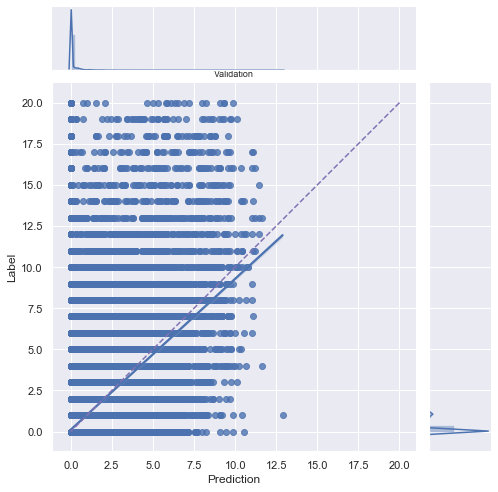

In [76]:
model_performance_sc_plot(knn_val_pred, Y_validation.item_cnt_month, 'Validation')

In [77]:
first_level = pd.DataFrame(catboost_val_pred, columns=['catboost'])
first_level['xgbm'] = xgb_val_pred
first_level['random_forest'] = rf_val_pred
first_level['linear_regression'] = lr_val_pred
first_level['knn'] = knn_val_pred
first_level['label'] = Y_validation.values
first_level.head(20)

,catboost,xgbm,random_forest,linear_regression,knn,label
0,0.70,0.70,0.62,0.60,1.00,0
1,0.83,0.64,0.56,0.04,0.78,0
2,0.04,0.10,0.21,0.04,0.00,0
3,1.10,0.81,0.95,0.04,0.11,4
4,2.06,1.59,1.57,1.46,0.67,1
5,0.70,0.64,0.46,0.04,0.11,1
6,0.44,0.43,0.21,0.04,0.11,0
7,0.04,0.10,0.06,0.04,0.00,1
8,0.36,0.38,0.21,0.04,0.11,0
9,1.79,1.73,1.13,1.15,2.89,2


In [78]:
first_level_test = pd.DataFrame(catboost_test_pred, columns=['catboost'])
first_level_test['xgbm'] = xgb_test_pred
first_level_test['random_forest'] = rf_test_pred
first_level_test['linear_regression'] = lr_test_pred
first_level_test['knn'] = knn_test_pred
first_level_test.head()

,catboost,xgbm,random_forest,linear_regression,knn
0,0.43,0.41,0.95,0.85,0.89
1,0.04,0.08,0.06,0.06,0.00
2,0.52,0.52,0.85,1.79,1.11
3,0.04,0.08,0.00,0.06,0.00
4,0.04,0.08,0.06,0.06,0.00


<h3>second level 

In [79]:
meta_model = LinearRegression(n_jobs=-1)
first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level, Y_validation.item_cnt_month)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [81]:
ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)

In [82]:
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_pred, Y_validation)))

Train rmse: 0.7647803368468175


In [83]:
prediction_df = pd.DataFrame(test['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = final_predictions.clip(0., 20.)

In [85]:
prediction_df.to_csv(r'C:\Users\Qianyu\Downloads\competitive-data-science-predict-future-sales\submission.csv', index=False)

<h4> RMSE for test result: 1.13816 according to Kaggle